#Full script for data analysis from sensor box

The start date is 2015-07-02 17:00:00, the end date 2015-07-03 17:00:00, the device number is 53ff6d066667574831402467.
Created link: http://109.237.25.161/particle/events?start_date=2015-07-02 17:00:00&end_date=2015-07-03 17:00:00&device=53ff6d066667574831402467

Data was fetched.

The signals were Gauss filterd.

For this selection, the min and max of light are 3.4e+02 and 3.3e+03 respectively.
For this selection, the min and max of noise_var are 2.3 and 9.7e+03 respectively.
For this selection, the min and max of pir_per are 0.0 and 7.8e+01 respectively.


The signals were normalised.



/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


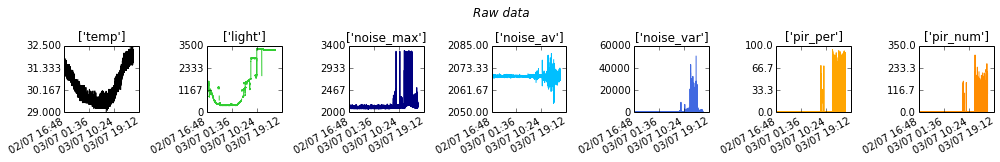

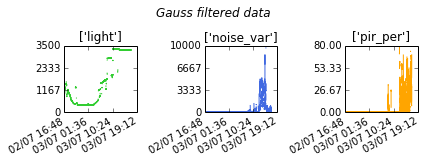

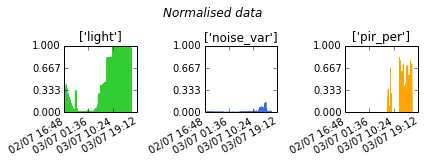

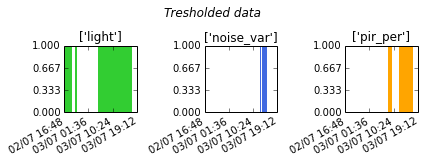

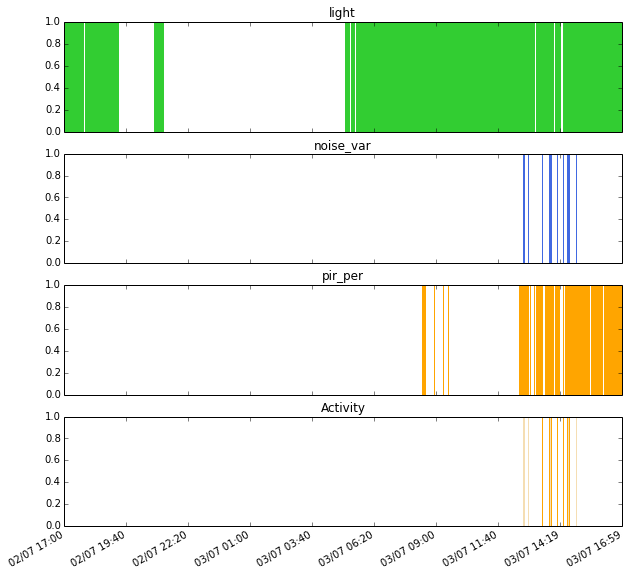

In [62]:
#LOADING PACKAGES
import numpy as np
import pandas as pd

#GUI
import Tkinter as tk

#load data from server and handle json and timestamp
import urllib2
import simplejson as json
from datetime import datetime

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import dates as mdates
from matplotlib.ticker import LinearLocator


###-----FUNCTIONS-----### 

class server_GUI(tk.Frame):
    def __init__(self, parent, date_format, *args, **kwargs):
        tk.Frame.__init__(self, parent, *args, **kwargs)
        self.grid()
        self.parent = parent
        self.date_format = date_format
        
        self.link = ""
        self.devices = ['53ff6d066667574831402467','54ff69066667515129441567']
        self.device = tk.StringVar(self.parent)
        
        self.initial_value = ['Hour','Day','07','2015']
        self.all_options = [['%02d'%(i) for i in range(0,24)],['%02d'%(i) for i in range(1,32)],['%02d'%(i) for i in range(1,13)],range(2015,2016)]
        
    def select_date(self):
        #DEVICE
        self.device.set('53ff6d066667574831402467')
        tk.Label(self.parent, text="Select device:").grid(row=0,column=0)
        apply(tk.OptionMenu, (self.parent, self.device) + tuple(self.devices)).grid(row=0,column=1)
        
        #START DATE
        tk.Label(self.parent, text="Select start date:").grid(row=1)
        self.var_start = [tk.StringVar(self.parent) for i in range(len(self.initial_value))]
        for i in range(len(self.initial_value)):
            self.var_start[i].set(self.initial_value[i])
            apply(tk.OptionMenu, (self.parent, self.var_start[i]) + tuple(self.all_options[i])).grid(row=2,column=i)
        
        #END DATE
        tk.Label(self.parent, text="Select end date:").grid(row=3)
        self.var_end = [tk.StringVar(self.parent) for i in range(len(self.initial_value))]
        for i in range(len(self.initial_value)):
            self.var_end[i].set(self.initial_value[i])
            apply(tk.OptionMenu, (self.parent, self.var_end[i]) + tuple(self.all_options[i])).grid(row=4,column=i)
        
        tk.Button(self.parent, text='OK', command=self.ok).grid(row=5,column=5)
        
    def ok(self):
        try:
            start = datetime(int(self.var_start[3].get()),int(self.var_start[2].get()),int(self.var_start[1].get()),int(self.var_start[0].get()))
            end =  datetime(int(self.var_end[3].get()),int(self.var_end[2].get()),int(self.var_end[1].get()),int(self.var_end[0].get()))
            print "The start date is {}, the end date {}, the device number is {}.".format(start.strftime(self.date_format),end.strftime(self.date_format),self.device.get())
            
            self.link = "http://109.237.25.161/particle/events?start_date={}&end_date={}&device={}".format(start.strftime(self.date_format),end.strftime(self.date_format),self.device.get())
            print "Created link: {}\n".format(self.link)
            
            self.parent.quit()
            
        except:
            print "Please try again!"

def load_data(link, date_format):
    buf = []
    dat = []
    timestamp = []
    
    decoded_json = json.loads(urllib2.urlopen(link).read())['events']
    
    for line in decoded_json:
        buf = [x.strip() for x in line['data'].split(",")]
        if len(buf)==5:
                dat.append(buf)
                timestamp.append(datetime.strptime(line['timestamp'],date_format))
        elif len(buf)==2:
                try:
                    dat[-1].append(buf[0])
                    dat[-1].append(buf[1])
                except IndexError:
                    continue
        else:
                #continue
                ###Nan handling:
                dat.append([np.nan]*7)
                timestamp.append(datetime.strptime(line['timestamp'],date_format))

    print "Data was fetched.\n"
    return timestamp,dat
    
def new_format(dat):
    new = np.zeros((len(dat),7), dtype=float)*np.nan
    
    #split ["variable1: value1"] into [["variable1:" , "value1"]]    
    for j in range(len(dat)):
        if all(pd.isnull(dat[j]))==False:
            for i in range(len(dat[j])):
                dat[j][i] = dat[j][i].split()
        else:
            continue
            
    #add values to "new" array
    for j in range(len(dat)):
        for i in range(len(dat[i])):
                if type(dat[j][i])==list:
                    new[j][i] = dat[j][i][1]
                else:
                    continue
                    
    return new

def make_df(data,timestamp,col_names):
    df = pd.DataFrame(data, index=timestamp, columns=col_names)
    df = df.convert_objects(convert_numeric=True)
    
    return df

def plot_data(df,hfmt,cols,title,plt_type):
    var = df.columns.values
    
    fig, axs = plt.subplots(1,len(var), sharex=True, figsize=(2*len(var),2))
    fig.suptitle(title,y=1.1,fontsize=12,style='oblique')

    for i in range(len(var)):
        if plt_type=='line':
            axs[i].plot(df.index,df[var[i]].values,color=cols[var[i]])
        elif plt_type=='fill':
            axs[i].fill_between(df.index,0,df[var[i]].values,color=cols[var[i]])
            axs[i].set_ylim(0,1)
        else:
            print "plt_type invalid!"
            break
        axs[i].set_title([var[i]],fontsize=12)
        axs[i].xaxis.set_major_formatter(hfmt)
        axs[i].xaxis.set_major_locator(LinearLocator(numticks=4))
        axs[i].yaxis.set_major_locator(LinearLocator(numticks=4))
    
    fig.autofmt_xdate()
    fig.tight_layout()
    #fig.show()
    #fig.savefig(title,orientation="landscape")
        
def Gauss_filt(y, M, std):
    from scipy.signal import gaussian
    from scipy.ndimage import filters

    b = gaussian(M, std)
    ga = filters.convolve1d(y, b/b.sum())
    
    return ga

def filt_data(df,var,filt_params):
    filt_sig = np.zeros((len(df.index),len(var)))*np.nan
    
    for i in range(len(var)):
        ##find slices of df which are not NaN
        mask = np.ma.clump_unmasked(np.ma.masked_invalid(df[var[i]].values))
        ##Gauss filter these slices
        for s in range(len(mask)):
            filt_sig[mask[s],i] = Gauss_filt(df[var[i]].values[mask[s]],filt_params[var[i]][0],filt_params[var[i]][1])
    
    print "The signals were Gauss filterd.\n"
    return make_df(filt_sig,df.index,var)

def norm_filt_data(df,min_max,cols):
    var = df.columns.values
    norm_sig = np.zeros(df.shape,dtype=float)*np.nan
    
    for i in range(len(var)):
        norm_sig[:,i] = (df[var[i]]-min_max[var[i]][0])/(min_max[var[i]][1]-min_max[var[i]][0])
        print "For this selection, the min and max of {0} are {1:.2} and {2:.2} respectively.".format(var[i], np.nanmin(df[var[i]].values), np.nanmax(df[var[i]].values))

    print "\n"
    print "The signals were normalised.\n"
    
    return make_df(norm_sig,df.index,var)

def treshold_data(df,treshold):
    lines = np.zeros(df.shape, dtype=int)*np.nan
    var = df.columns.values
        
    for i in range(len(var)):
        lines[:,i] = [1 if x>treshold[var[i]] else np.nan for x in df[var[i]]]
    
    return make_df(lines,df.index,var)
    
def infere(df):
    ###This is still not generalised enough for all parameters we record!!!
    
    day_high = [1 if (x==1 and y==1 and z==1) else np.nan for (x,y,z) in df.values]
    day_low = [1 if (x==1 and y==1 and np.isnan(z)) else np.nan for (x,y,z) in df.values]
    night_high = [1 if (np.isnan(x) and np.isnan(y) and z==1) else np.nan for (x,y,z) in df.values]
    night_low = [1 if (np.isnan(x) and y==1 and np.isnan(z)) else np.nan for (x,y,z) in df.values]
    
    activity = np.array([day_high,day_low,night_high,night_low])
    levels = ["day_high","day_low","night_high","night_low"]
  
    return make_df(activity.T,df.index,levels)

def line_plot(df_tresh,df_act,hfmt,cols):
    var = df_tresh.columns.values
    levels = df_act.columns.values
    
    fig, axs = plt.subplots(len(var)+1, 1, sharex=True, sharey=True, figsize=(10,10))

    for i in range(len(var)):
        axs[i].fill_between(df_tresh.index,0,df_tresh[var[i]],color=cols[var[i]])
        axs[i].set_title("{}".format(var[i]))
    
    lev_cols = ["orange","wheat","darkcyan","lightcyan"]
    for j in range(len(levels)):
        axs[len(var)].fill_between(df_act.index,0,df_act[levels[j]],color=lev_cols[j])
        axs[len(var)].set_title("Activity")

    axs[0].xaxis.set_major_locator(LinearLocator(numticks=10))
    axs[0].xaxis.set_major_formatter(hfmt)
    axs[0].set_ylim(0,1)
    
    fig.autofmt_xdate()
    
def main():
    ###-----SETUP-----### 
    #format of input
    date_format = '%Y-%m-%d %H:%M:%S' #format of timestamp
    params = ["temp","light","noise_max","noise_av","noise_var","pir_per","pir_num"] #parameters in dataset
    
    #parameters to be analysed
    para = [params[1],params[4],params[5]] #parameters used for analysis
    
    #input for gaussian filter ["number of points in output window","sigma"]
    filt_params = {
        "temp":[27,32],
        "light":[100,60],
        "noise_max":[2072,3298],
        "noise_av":[2054,2087],
        "noise_var":[20,15],
        "pir_per":[15,5],
        "pir_num":[15,5]
    }
    
    #minimum and maximum for each paramater between 29/06 and 05/07 (EIETL data); used to normalise data
    min_max = {
            "temp":[27.7,32.6],
            "light":[341.,3380.],
            "noise_max":[2072.,3298.],
            "noise_av":[2054.5,2087.8],
            "noise_var":[1.7,66404.3],
            "pir_per":[0.,95.],
            "pir_num":[0.,301.]
    }

    #tresholds above which paramter is switched to 1 and below which it is set to NaN (empirical)
    tresholds = {
            "temp":[.2],
            "light":[.1],
            "noise_max":[.05],
            "noise_av":[.05],
            "noise_var":[.05],
            "pir_per":[.05],
            "pir_num":[.05]
    }
    
    #plot setup
    hfmt = mdates.DateFormatter('%d/%m %H:%M') #display format of date
    cols = {
        "temp":"black",
        "light":"limegreen",
        "noise_max":"navy",
        "noise_av":"deepskyblue",
        "noise_var":"royalblue",
        "pir_per":"orange",
        "pir_num":"darkorange"
    }
    
    ###-----ANALYSIS-----### 
    
    #CALL GUI TO SELECT DATE
    root = tk.Tk()
    root.title('Select data to be fetched')

    App = server_GUI(root,date_format)
    App.select_date()

    root.mainloop()
    root.destroy()
    
    #DECODE JSON FORMAT
    timestamp,dat = load_data(App.link,date_format)
    device = App.device.get()
    
    #NEW OR OLD DATA FORMAT?
    if device=='54ff69066667515129441567':
        dat = new_format(dat)
    
    #MAKE DATA FRAME (USING ALL PARAMETERS)
    df = make_df(dat,timestamp,params)
    plot_data(df,hfmt,cols,"Raw data","line")
    
    #FILTER THE DATA (ONLY OF THE SUBSET "PARA" OF PARAMETERS)
    df_filt = filt_data(df,para,filt_params)
    plot_data(df_filt,hfmt,cols,"Gauss filtered data","line")
    
    #NORMALISE THE FILTERED DATA 
    df_norm = norm_filt_data(df_filt,min_max,cols)
    plot_data(df_norm,hfmt,cols,"Normalised data","fill")
    
    #TRESHOLD THE NORMALISED DATA
    df_tresh = treshold_data(df_norm,tresholds)
    plot_data(df_tresh,hfmt,cols,"Tresholded data","fill")
    
    df_activity = infere(df_tresh)
    line_plot(df_tresh,df_activity,hfmt,cols)

# call main
if __name__ == '__main__':
    main()